In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.transform import resize
from skimage import img_as_ubyte
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial import distance as ssd

In [90]:
from gensim.models import FastText
from skimage.transform import resize
from skimage import img_as_ubyte
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial import distance as ssd

import random
import sys
# import utils
import cv2
import numpy as np
import pandas as pd
import pygame
import pygame.camera
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time
import threading
import pyautogui
from PIL import Image, ImageEnhance

IMAGE_SIZE = 256

In [68]:
num_classes = 8
IMAGE_SIZE = 256
BGCOLOR = (0, 0, 0)

SEGCOLOR = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255), (255, 255, 0), (255, 0, 255),
            (0, 0, 192), (0, 192, 0), (192, 0, 0), (0, 192, 128), (192, 192, 0), (192, 0, 192),
            (0, 0, 128), (0, 128, 0), (128, 0, 0), (0, 128, 128), (128, 128, 0), (128, 0, 128),
            (0, 0, 64), (0, 64, 0), (64, 0, 0), (0, 64, 64), (64, 64, 0), (64, 0, 64),
            (0, 0, 32), (0, 32, 0), (32, 0, 0), (0, 32, 32), (32, 32, 0), (32, 0, 32)]

## 만다라 처리 클래스
class Mandala:
    def __init__(self, image):
        self.org_mandala = image
        self.aft_mandala = None
        self.height, self.width = self.org_mandala.shape[0], self.org_mandala.shape[1]
        self.edge_image = None
        self.mask = None
        self.masked = None
        self.coord = None
        self.labels, self.prop_labels, self.area_crop = None, None, None
        self.analyze_mandala()

    def mean_iou(self, y_true, y_pred):  # 모델에 사용되는 loss
        intersection = tf.reduce_sum(tf.where((y_pred > 0.5) & (y_true == 1), 1, 0))
        union = tf.reduce_sum(tf.where((y_pred > 0.5) | (y_true == 1), 1, 0))
        return intersection / union

    def extend_canvas(self, ori, symmetry=False):  # 만다라에 여백 만들기
        h, w = ori.shape[:2]
        img = np.ones((h + 50, w + 50, 3), dtype='uint8') * 255
        img[25:h + 25, 25:w + 25, :] = ori

        h, w = img.shape[:2]

        if symmetry == True:
            img[h // 2:, w // 2:, :] = img[:h // 2, :w // 2, :][::-1, ::-1, :]
            img[h // 2:, :w // 2, :] = img[:h // 2, :w // 2, :][::-1, :, :]
            img[:h // 2, w // 2:, :] = img[:h // 2, :w // 2, :][:, ::-1, :]
        return img

    def get_partitions(self, img, masked):
        global star
        _, labels, stats, centroids = cv2.connectedComponentsWithStats(masked, connectivity=4)
        gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgh, imgw = img.shape[0], img.shape[0]
        area_crop, prop_labels, coord = [], [], []
        unique, counts = np.unique(labels, return_counts=True)

        for i in unique:
            tmp = np.zeros_like(gimg)
            tmp[labels == i] = 255

            x, y, w, h = cv2.boundingRect(tmp)
            if np.sum(labels == i) < 30 or w < 2 or h < 2 or y < 2 or x < 2 or y + h > imgh - 2 or x + w > imgw - 2:
                continue
            area_crop.append(tmp[y:y + h, x:x + w])
            prop_labels.append(i)
            coord.append(np.sqrt(((y + h / 2) / imgh - 0.5) ** 2 + ((x + w / 2) / imgw - 0.5) ** 2))

        self.labels, self.prop_labels, self.area_crop, self.coord = labels, prop_labels, area_crop, coord
        
    def repaint(self, used_colors, current, segcolor):

        out = np.ones_like(self.edge_image) * 255
        for i, c in enumerate(self.cluster):
            out[self.labels == self.prop_labels[i]] = segcolor[int(c % len(segcolor))]
        out[np.where((self.edge_image == (0, 0, 0)).all(axis=-1))] = (0, 0, 0)

        for c in used_colors:
            target_area_c = np.median(out[(current == c).all(axis=-1)].reshape((-1, 3)), axis=0)
            if ~((target_area_c == c).all(axis=-1)):
                target_area_idx = (current == c).all(axis=-1)
                out[target_area_idx] = c
        return out

    def color_partitions(self, current=None, colorlist=None, num_classes=14, mode='recommendation'):
        if mode == 'recommendation':
            if current is None:
                current = self.edge_image.copy()
            num_areas = len(self.area_crop)
            sim_mat = np.zeros((num_areas, num_areas))
            label_mean = np.array([current[self.labels == i].mean(0) for i in self.prop_labels])

            for i in range(0, num_areas):
                for j in range(0, num_areas):
                    if i >= j:
                        continue
                    elif (label_mean[i] == (255, 255, 255)).all(axis=-1) or \
                            (label_mean[j] == (255, 255, 255)).all(axis=-1):
                        im1 = np.array(self.area_crop[i])
                        im2 = np.array(self.area_crop[j])
                        sim_mat[i][j] = cv2.matchShapes(im1, im2, cv2.CONTOURS_MATCH_I2, 0) + 0.5 * abs(
                            self.coord[i] - self.coord[j])
                    elif (label_mean[i] == label_mean[j]).all(axis=-1):
                        sim_mat[i][j] = 0.01
                    else:
                        sim_mat[i][j] = 1000

                    sim_mat[j][i] = sim_mat[i][j]
            Zd = linkage(ssd.squareform(sim_mat), method="complete")

            self.cluster = fcluster(Zd, num_classes, criterion="maxclust") - 1

            self.cids, _ = np.unique(self.cluster, return_counts=True, axis=0)
            self.sim_mat = sim_mat

        used_colors = np.unique(current.reshape((-1, 3)), axis=0)
        used_colors = used_colors[~((used_colors == (255, 255, 255)).all(axis=-1))]
        colored_mandalas = []
        if colorlist is None:
            segcolor = SEGCOLOR
            out = self.repaint(used_colors, current, segcolor)
            colored_mandalas.append(([255, 255, 255] * 6, out))
        else:
            for key in colorlist.keys():
                ip_color, rc_color = colorlist[key][0], colorlist[key][1] + [[-1, -1, -1]]
                if len(ip_color) >= 5:
                    ip_color = ip_color[:5]
                ip_color = random.sample(ip_color, random.randint(0, min(len(ip_color) - 1, 2)))
                idx, cnt = 0, 6 - len(ip_color)
                while idx + cnt < len(rc_color):
                    shuffled = rc_color[idx:idx + cnt]
                    random.shuffle(shuffled)
                    segcolor = ip_color + shuffled
                    out = self.repaint(used_colors, current, segcolor)
                    colored_mandalas.append((ip_color + shuffled, out))
                    idx += 1
        random.shuffle(colored_mandalas)
        return colored_mandalas

    def analyze_mandala(self):
        extended = self.extend_canvas(self.org_mandala, symmetry=True)
        # get_edge
        gimg = cv2.cvtColor(extended, cv2.COLOR_BGR2GRAY)
        _, th = cv2.threshold(255 - gimg, 50, 255, cv2.THRESH_BINARY)
        edge_image = np.stack((255 - th,) * 3, axis=-1)
        self.edge_image = edge_image

        # get_mask
        gimg = cv2.cvtColor(edge_image, cv2.COLOR_BGR2GRAY)
        _, th2 = cv2.threshold(255 - gimg, 50, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        mask = np.ones_like(th2) * 255
        cv2.drawContours(mask, contours, -1, 0, -1)
        self.mask = mask

        masked = cv2.bitwise_and(255 - th2, 255 - th2, mask=255 - mask)

        masked2 = np.stack((masked,) * 3, axis=-1).reshape(-1, 3)
        alist, a = np.unique(masked2, return_counts=True, axis=0)

        self.allblack = a[0]  # 배경 테두리 검정색값
        self.masked = masked
        self.get_partitions(edge_image, masked)

In [84]:
##만다라 색상추천 클래스
class Coloring:
    def __init__(self, ip_colors=None):
        if ip_colors is None:
            ip_colors = [[255, 255, 255]] * 6
        self.model = FastText.load('model/col2vec_fasttext.model')
        self.ip_colors = ip_colors
        self.colorlist = {}

    def rgb_to_hex(self, color):
        r, g, b = color
        return (hex(r)[2:].zfill(2) + hex(g)[2:].zfill(2) + hex(b)[2:].zfill(2)).upper()

    def hex_to_rgb(self, value):
        lv = len(value)
        return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

    def recommend_palette(self, idx, state, color_info):
        ratio, used_colors = zip(*color_info)
        w_lis = None
        if state == 'initial':
            w_lis = [self.rgb_to_hex(used_colors[1])]
        elif state == 'colorized':
            w_lis = [self.rgb_to_hex(c) for r, c in zip(ratio[1:], used_colors[1:]) if r / sum(ratio[1:]) >= 0.1]

        recommend_w_colors = self.model.wv.most_similar(w_lis)
        recommend_w_pal = [list(self.hex_to_rgb(rc[0])) for rc in recommend_w_colors]

        self.colorlist[idx] = {'w_palette': ([list(self.hex_to_rgb(c)) for c in w_lis], recommend_w_pal)}


##만다라 변경사항 업데이트 클래스
class UpdateMandala:
    def __init__(self, image):
        self.mandala = Mandala(image)
        self.colors = Coloring()
        self.color_info = [[1, [125, 125, 125]]]  # zip(ratio, color RGB)
        self.user_mandala = None
        self.colored_mandalas = None

    def ratio_used_colors(self, used_colors_cnts):  # current_quant, mask
        used_colors_cnts[0] = used_colors_cnts[0] - self.mandala.allblack
        if used_colors_cnts[0] <= 0:
            used_colors_cnts[0] = 0
        per = used_colors_cnts / np.array(used_colors_cnts).sum()
        per = per.round(3)
        return per

    def quantization(self, current):
        extended = self.mandala.extend_canvas(current, symmetry=False)
        coloring = self.mandala.edge_image.copy()

        used_colors = []
        for l in self.mandala.prop_labels:
            area = extended[self.mandala.labels == l]
            uqe = np.unique(extended[self.mandala.labels == l] // 25, axis=0, return_counts=True)
            if (np.sum(self.mandala.labels == l) > 100 or np.mean(np.std(area, axis=-1)) > 50) and np.sum(
                    uqe[1][(uqe[0] == (10, 10, 10)).all(axis=-1)]) / np.sum(uqe[1]) < 0.3:
                coloring[self.mandala.labels == l] = area
                c = np.mean(area[~(area == (255, 255, 255)).all(axis=-1)], axis=0).astype(np.uint8)
                coloring[self.mandala.labels == l] = c
                used_colors.append(c)
        if used_colors != []:
            used_colors_hsv = cv2.cvtColor(np.expand_dims(used_colors, axis=0), cv2.COLOR_BGR2HSV)[0]
            coloring_hsv = cv2.cvtColor(coloring, cv2.COLOR_BGR2HSV)

            clt = KMeans(n_clusters=1)
            clt.fit(used_colors)
            baseline = clt.inertia_

            cluster, center = [], []
            for i in range(2, min(len(used_colors), 12)):
                clt = KMeans(n_clusters=i)
                clt.fit(used_colors_hsv)
                cluster = clt.predict(used_colors_hsv)
                center = clt.cluster_centers_.astype(np.int32)

                if (baseline - clt.inertia_) / baseline < 0.1:
                    break
                baseline = clt.inertia_

            for i, c in enumerate(used_colors_hsv):
                coloring_hsv[(coloring_hsv == c).all(axis=-1)] = center[cluster[i]]

            coloring = cv2.cvtColor(coloring_hsv, cv2.COLOR_HSV2BGR)

            used_colors, used_colors_cnts = np.unique(
                (coloring - self.mandala.mask.reshape(coloring.shape[0], coloring.shape[0], 1)).reshape(-1, 3),
                return_counts=True, axis=0)
            color_ratio = self.ratio_used_colors(used_colors_cnts)
        else:
            color_ratio = [1]
        if color_ratio[-1] >= 0.98:
            color_ratio = [0.5, 0.5]
            new_used_colors = [[255, 255, 255]] + [[random.randint(0, 255) for _ in range(3)]]
            self.color_info = list(zip(color_ratio, new_used_colors))
            state = 'initial'  # 색칠하지 않은 스케치가 들어가는 경우
        else:
            self.color_info = sorted(zip(color_ratio, used_colors), key=lambda x: x[0], reverse=True)
            state = 'colorized'  # 유저가 색칠한 스케치가 들어가는 경우
        return state, coloring

    def fill_current_image(self, current):
        out = current.copy()
        for i, l in enumerate(self.mandala.prop_labels):
            c = np.median(current[self.mandala.labels == l], axis=0)

            uqe = np.unique(current[self.mandala.labels == l] // 25, axis=0, return_counts=True)

            # 색칠되어 있으면 ...
            if np.sum(uqe[1][(uqe[0] == (10, 10, 10)).all(axis=-1)]) / np.sum(uqe[1]) < 0.1:
                idx = [k for k in np.argsort(self.mandala.sim_mat[i]) if self.mandala.sim_mat[i][k] < 0.01]
                # 이거랑 비슷한 곳들을 칠함
                for j in idx:
                    c2 = np.median(current[self.mandala.labels == self.mandala.prop_labels[j]], axis=0)
                    if (c2 == (255, 255, 255)).all(axis=-1):
                        out[self.mandala.labels == self.mandala.prop_labels[j]] = c
        return out

    def layered(self, seg):  # 그랩컷으로 단계 만듦
        sl = []
        # new_output에서 조각 정보 얻음
        self.mandala.get_partitions(seg, self.mandala.masked)
        labels, prop_labels, area_crop = self.mandala.labels, self.mandala.prop_labels, self.mandala.area_crop

        for k in range(20, 262, 40):
            s = seg.copy()
            out = np.ones_like(seg) * 255

            mask = np.zeros(seg.shape[:2], dtype='uint8')
            mask2 = np.zeros(seg.shape[:2], dtype='uint8')

            cv2.circle(mask, (int(seg.shape[0] / 2), int(seg.shape[0] / 2)), k + 30, 3, -1)
            cv2.circle(mask, (int(seg.shape[0] / 2), int(seg.shape[0] / 2)), k, 1, -1)
            cv2.grabCut(s, mask, None, None, None, 3, cv2.GC_INIT_WITH_MASK)

            la = labels.copy()
            la[np.where((mask == 0))] = 0
            labels_in_cir = np.unique(la)

            for i in labels_in_cir:
                l_piece = np.zeros_like(labels,
                                        dtype='uint8')  # labels(조각들) 사용해서 predicted image랑 비교   # numpy broadcasting 연산?
                l_piece[labels == i] = 255

                cut_p = cv2.bitwise_and(l_piece, mask)
                overlab_p = cv2.bitwise_and(l_piece, cut_p)

                overlap_area = cv2.countNonZero(overlab_p)
                p_area = cv2.countNonZero(l_piece)

                if overlap_area / p_area > 0.4:
                    mask2[labels == i] = 5
                else:
                    mask2[labels == i] = 8

            out[np.where((mask == 1) | (mask == 3))] = s[np.where((mask == 1) | (mask == 3))]
            out[np.where((mask2 == 5))] = s[np.where((mask2 == 5))]
            out[np.where((mask2 == 8))] = (255, 255, 255)
            sl = sl + [out]
        return sl

    def make_partial(self, colored_mandala):  # 그랩켯으로 레이어 별로 컬러이미지 생성
        pltt, md = colored_mandala[0], colored_mandala[1]
        partial = []
        sl = self.layered(md)
        for j in range(len(sl) - 1):
            tmp = sl[j].copy()
            tmp[np.where((md == (0, 0, 0)).all(axis=-1))] = md[np.where((md == (0, 0, 0)).all(axis=-1))]
            tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
            partial.append(tmp)
        return pltt, partial

    def update(self, current_mandala, clen, mode='recommendation'):
        global WORKING

        pltt, layers = None, None
        if mode == 'recommendation':
            cv2.imwrite('current_mandala.jpg', current_mandala)
            current = img_as_ubyte(resize(cv2.imread('current_mandala.jpg'), (512, 512)))[:, :, :3]
            state, quant_mand = self.quantization(current)
            WORKING = 0.2
            self.user_mandala = self.fill_current_image(quant_mand)
            self.colors.colorlist = {}
            WORKING = 0.5
            self.colors.recommend_palette(clen, state, self.color_info)  ## 입력 개수 다양하게 들어갈 수 있도록 수정하기 ##
            self.colored_mandalas = self.mandala.color_partitions(current=self.user_mandala,
                                                                  colorlist=self.colors.colorlist[clen],
                                                                  mode=mode)
            WORKING = 0.7
            print("Generate", len(self.colored_mandalas), "palettes.")
            pltt, layers = self.make_partial(self.colored_mandalas[clen])
        elif mode == 'change_palette':
            pltt, layers = self.make_partial(self.colored_mandalas[clen])
        return pltt, layers

In [3]:
md = Mandala(cv2.imread('9_org.jpg'))

In [88]:
input_img = 'c_10.jpg'
org_mandala = cv2.imread('9_org.jpg')
upman = UpdateMandala(org_mandala)

current_mandala = cv2.imread(input_img)

present_pltt, layers = upman.update(current_mandala, clen, mode='recommendation')

FileNotFoundError: [Errno 2] No such file or directory: 'model/col2vec_fasttext.model'

In [55]:
def extend_canvas(ori, symmetry = False):

    h, w = ori.shape[:2]
    img = np.ones((h+50, w+50, 3), dtype='uint8') * 255
    img[25:h+25,25:w+25,: ] = ori
    
    h, w = img.shape[:2]
    
    if symmetry == True:
        img[h//2:, w//2:, :] = img[:h//2, :w//2, :][::-1,::-1,:]
        img[h//2:, :w//2, :] = img[:h//2, :w//2, :][::-1,:,:]
        img[:h//2, w//2:, :] = img[:h//2, :w//2, :][:,::-1,:]

    return img

def get_edge(img):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(255 - gimg,50,255,cv2.THRESH_BINARY)
    edge_image = np.stack((255-th,)*3, axis = -1)
    
    return edge_image

def get_mask(img):

    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(255 - gimg,50,255,cv2.THRESH_BINARY)

    contours, _ = cv2.findContours( th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.ones_like(th) * 255
    cv2.drawContours(mask, contours, -1, 0, -1)
    
    return mask

def get_masked_area(img, mask):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(255 - gimg,50,255,cv2.THRESH_BINARY)

    masked = cv2.bitwise_and(255-th, 255-th, mask=255-mask)
    
    return masked

def extract_used_colors(current_quant, mask):
    used_colors, used_colors_cnts = np.unique( (current_quant- mask.reshape(current_quant.shape[0], current_quant.shape[0],1)).reshape(-1,3), return_counts=True, axis=0)
    #used_colors_cnts = used_colors_cnts[ ~(used_colors==(0,0,0)).all(axis=-1)]
    #used_colors = used_colors[ ~(used_colors==(0,0,0)).all(axis=-1)]
    return used_colors, used_colors_cnts
    

def get_partitions(img, masked ):
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(masked, connectivity=4)

    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    imgh, imgw = img.shape[0], img.shape[0]
    area_crop = []
    coord = []
    prop_labels = []
    unique, counts = np.unique(labels, return_counts=True)

    for i in unique:

        tmp = np.zeros_like(gimg)
        tmp[labels == i] = 255

        x,y,w,h = cv2.boundingRect(tmp)
        if np.sum(labels == i) < 30 or w < 2 or h <2 or y < 2 or x < 2 or y+h > imgh -2 or x +w > imgw-2:
            continue
        area_crop.append(tmp[y:y+h, x:x+w])
        prop_labels.append(i)
        coord.append( np.sqrt( ( (y + h/2)/imgh - 0.5 )**2 + ( (x + w/2)/imgw - 0.5)**2 ) ) 

    return labels, prop_labels, area_crop, coord

def color_partitions(labels, prop_labels, area_crop, coord, edge_image, current = None):

    if current is None:
        current = edge_image.copy()
        
    num_areas = len(area_crop)
    sim_mat=np.zeros((num_areas, num_areas))

    cluster=np.zeros(num_areas, dtype=int)
    
    label_mean = np.array([ current[labels==i].mean(0) for i in prop_labels ])

    for i in range(0,num_areas):
        for j in range(0, num_areas):
            
            if i >= j :
                continue
            elif ( label_mean[i] == (255,255,255)).all(axis=-1) or \
                ( label_mean[j] == (255,255,255)).all(axis=-1):
                im1=np.array(area_crop[i])
                im2=np.array(area_crop[j])
                sim_mat[i][j]= cv2.matchShapes(im1,im2,cv2.CONTOURS_MATCH_I2,0) + 0.5 * abs(coord[i] - coord[j])
            elif (label_mean[i] == label_mean[j]).all(axis=-1):
                sim_mat[i][j]=  0.01
            else:
                sim_mat[i][j]=  1000

            sim_mat[j][i]= sim_mat[i][j] 
    '''
     Cluster the contours using similarity matrix and max cluster no.
     Returns cluster vector  [Range: 0 - (num_classes-1)]
    '''
    Zd = linkage(ssd.squareform(sim_mat), method="complete") 
    cluster = fcluster(Zd, num_classes, criterion='maxclust') - 1 

    cids, cluster_cnt = np.unique(cluster, return_counts=True, axis = 0)
    
    seg_color_idx = []
    out = np.ones_like(edge_image) * 255

    for i, c in enumerate(cluster):
        out[labels==prop_labels[i]] = SEGCOLOR[c]
        seg_color_idx += [c]
        
    seg_color_idx = np.unique(seg_color_idx)
        
    out[np.where( (edge_image==(0,0,0)).all(axis=-1))] = (0,0,0)   
    
#     used_colors = np.unique(current.reshape((-1, 3)), axis = 0)
#     used_colors = used_colors[ ~( (used_colors==(255,255,255)).all(axis=-1) ) ]
#     unused_color_idx = [s for s in range(len(SEGCOLOR)) if s not in seg_color_idx]

#     for c in used_colors:

#         target_area_c = np.median(out[ (current==c).all(axis=-1) ] .reshape((-1, 3)), axis = 0)

#         if ~((target_area_c == c).all(axis=-1)):
#             target_area_idx = (out==target_area_c).all(axis=-1)
#             replace_color_idx = (out==c).all(axis=-1)

#             out[replace_color_idx] = target_area_c
#             out[target_area_idx] = c
    
    return out, sim_mat



In [20]:
def ratio_used_colors(used_colors_cnts):  # current_quant, mask
    used_colors_cnts[0] = used_colors_cnts[0] - md.allblack
    if used_colors_cnts[0] <= 0:
        used_colors_cnts[0] = 0
    per = used_colors_cnts / np.array(used_colors_cnts).sum()
    per = per.round(3)
    return per

def quantization(current):
    extended = md.extend_canvas(current, symmetry=False)
    coloring = md.edge_image.copy()

    used_colors = []
    for l in md.prop_labels:
        area = extended[md.labels == l]
        uqe = np.unique(extended[md.labels == l] // 25, axis=0, return_counts=True)
        if (np.sum(md.labels == l) > 100 or np.mean(np.std(area, axis=-1)) > 50) and np.sum(
                uqe[1][(uqe[0] == (10, 10, 10)).all(axis=-1)]) / np.sum(uqe[1]) < 0.3:
            coloring[md.labels == l] = area
            c = np.mean(area[~(area == (255, 255, 255)).all(axis=-1)], axis=0).astype(np.uint8)
            coloring[md.labels == l] = c
            used_colors.append(c)

    used_colors_hsv = cv2.cvtColor(np.expand_dims(used_colors, axis=0), cv2.COLOR_BGR2HSV)[0]
    coloring_hsv = cv2.cvtColor(coloring, cv2.COLOR_BGR2HSV)

    clt = KMeans(n_clusters=1)
    clt.fit(used_colors)
    baseline = clt.inertia_

    cluster, center = [], []
    for i in range(2, min(len(used_colors), 12)):
        clt = KMeans(n_clusters=i)
        clt.fit(used_colors_hsv)
        cluster = clt.predict(used_colors_hsv)
        center = clt.cluster_centers_.astype(np.int32)

        if (baseline - clt.inertia_) / baseline < 0.1:
            break
        baseline = clt.inertia_

    for i, c in enumerate(used_colors_hsv):
        coloring_hsv[(coloring_hsv == c).all(axis=-1)] = center[cluster[i]]

    coloring = cv2.cvtColor(coloring_hsv, cv2.COLOR_HSV2BGR)
    mask = md.mask.copy()
    used_colors, used_colors_cnts = np.unique(
        (coloring - mask.reshape(coloring.shape[0], coloring.shape[0], 1)).reshape(-1, 3),
        return_counts=True, axis=0)
    color_ratio = ratio_used_colors(used_colors_cnts)
        
    color_info = sorted(zip(color_ratio, used_colors), key=lambda x: x[0], reverse=True)

    return color_info, coloring

def image_registration(ref_img, reg_img):
    ref_img = cv2.resize(ref_img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
    reg_img = cv2.resize(reg_img, dsize=(512, 512), interpolation=cv2.INTER_AREA)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
    can_ref = cv2.Canny(ref_gray, 0, 175)
    can_ref = cv2.dilate(can_ref, kernel, iterations=2)

    reg_gray = cv2.cvtColor(reg_img, cv2.COLOR_BGR2GRAY)
    can_reg = cv2.Canny(reg_gray, 0, 175)
    can_reg = cv2.dilate(can_reg, kernel, iterations=2)

    height, width = reg_img.shape[:2]
    orb_detector = cv2.ORB_create(15000)

    kp1, d1 = orb_detector.detectAndCompute(can_reg, None)
    kp2, d2 = orb_detector.detectAndCompute(can_ref, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = matcher.match(d1, d2)
    matches.sort(key=lambda x: x.distance)

    matches = matches[:int(len(matches) * 90)]
    no_of_matches = len(matches)

    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))
    for i in range(len(matches)):
        p1[i, :] = kp1[matches[i].queryIdx].pt
        p2[i, :] = kp2[matches[i].trainIdx].pt

    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
    transformed_img = cv2.warpPerspective(reg_img,
                                          homography, (width, height), borderValue=(255, 255, 255))
    transformed_img[(transformed_img > 200).all(axis=-1)] = 255
    return transformed_img


C:\Users\USER\anaconda3\envs\hai\lib\site-packages\sklearn\cluster\_kmeans.py:1040: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


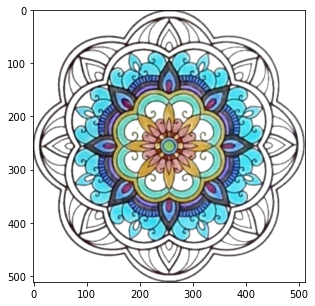

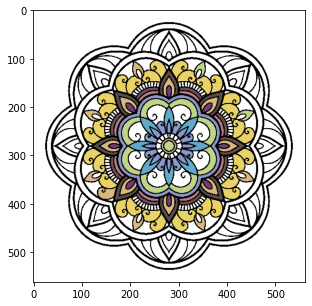

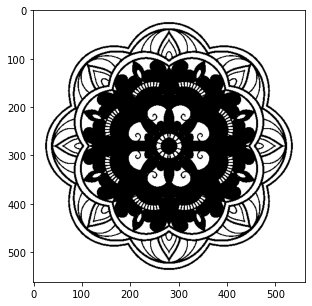

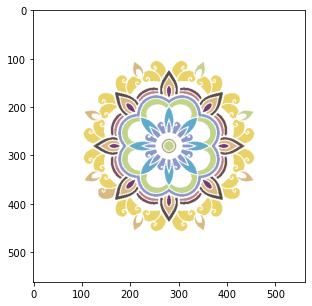

In [5]:
current = img_as_ubyte(resize(cv2.imread('./210929_JNY/usr_man/10.jpg'), (512, 512)))[:, :, :3]

regi = image_registration(cv2.imread('9_org.jpg'), current)
color_info, quant_mand = quantization(current)

# cv2.imwrite('quant1.jpg', quant_mand)
# cv2.imwrite('quant1.jpg', quant_mand)

plt.figure(figsize=(5,5))
plt.imshow(regi)
plt.show()

# print(color_info)
rgb = cv2.cvtColor(quant_mand, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(rgb)
plt.show()

test = rgb.copy()
test[(test != (255,255,255)).all(axis=-1)] = [0,0,0]
plt.figure(figsize=(5,5))
plt.imshow(test)
plt.show()

res = cv2.bitwise_and(rgb, 255-test)
res[(res == (0,0,0)).all(axis=-1)] = [255,255,255]


plt.figure(figsize=(5,5))
plt.imshow(res)
plt.show()

# cv2.imwrite('area.jpg', test)

res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
# cv2.imwrite('color_area.jpg', res)

In [81]:
num_classes=6

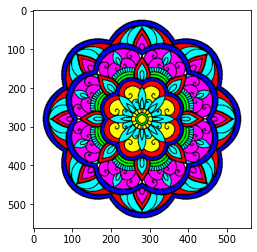

In [82]:
path = '9_org.jpg'
img = cv2.imread(path)

ext_img = extend_canvas(img)
edge_image = get_edge(ext_img)
mask = get_mask(ext_img)
masked = get_masked_area(ext_img, mask)
labels, prop_labels, area_crop, coord = get_partitions(ext_img, masked)
plt.imshow(labels,)

final_output, cids = color_partitions(labels, prop_labels, area_crop, coord, edge_image)
plt.imshow(final_output,)
# color_segments = get_each_color_seg(final_output)

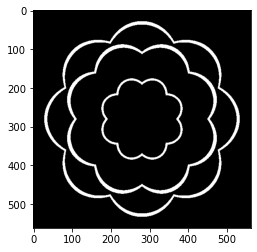

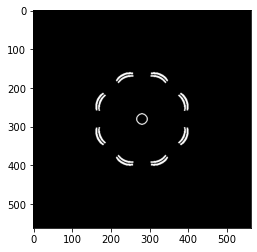

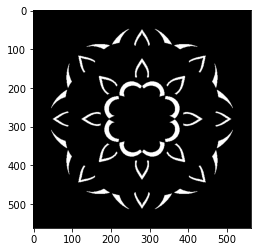

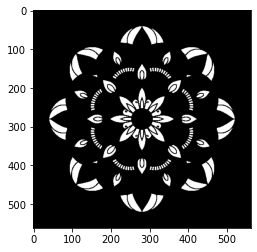

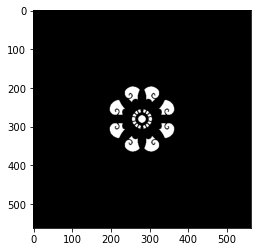

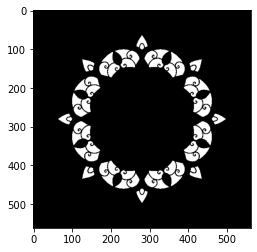

In [83]:
for i, c in enumerate(SEGCOLOR[:num_classes]) :
    out = np.zeros_like(final_output)
    out[(final_output == c).all(axis=-1)]=(255,255,255)
    cv2.imwrite('clustering_output/c_%i.jpg'%i, out)
    plt.imshow(out)
    plt.pause(0.001)
plt.show()

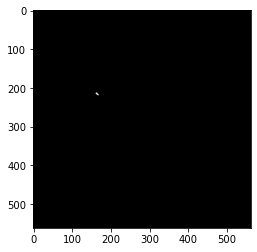

In [45]:
out = np.zeros_like(edge_image)
out[labels==prop_labels[100]] = (255,255,255)
plt.imshow(out)

In [37]:
cids[0]

array([0.        , 1.42881069, 1.42881069, 1.34354739, 1.34354739,
       1.21968712, 1.21968712, 1.11924576, 1.49396034, 1.62264486,
       1.19269508, 0.14753923, 1.19269508, 1.32620973, 1.32620973,
       1.55007872, 1.55007872, 1.42091229, 1.42091229, 1.51604988,
       1.51604988, 1.39571391, 1.39571391, 1.55175906, 1.55175906,
       1.43179333, 1.43179333, 1.08774417, 1.08774417, 1.44192178,
       1.44192178, 1.50565498, 1.03375306, 1.50565498, 1.48317032,
       1.48259835, 1.52094957, 1.52094957, 1.34827328, 1.34827328,
       1.50627703, 1.50627703, 1.18900499, 1.18900499, 1.25820516,
       1.63296874, 1.63296874, 1.40599825, 1.46327065, 1.39533588,
       1.39533588, 1.46327065, 1.40599825, 1.41450266, 1.41450266,
       1.43320008, 1.43320008, 1.42765579, 1.42765579, 1.4262232 ,
       1.4262232 , 1.38857784, 1.36130468, 0.90873805, 0.90873805,
       1.36130468, 1.44313017, 1.44313017, 1.36939952, 1.36939952,
       0.91010962, 0.91010962, 1.00937932, 1.43715832, 1.43715